# 1. Binary Classification

### 1.1 Titanic, but correctly this time

Take your linear regression model from the workshop 3.3 on the titanic dataset.

Swap OLS for logistic regresssion and compare the classification model metrics (accuracy, ROC plot, F1, precision/recall).

How much better is logistic regression than OLS on binary data?

In [134]:
#loading the data
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

df=sns.load_dataset('titanic')

In [135]:
import itertools



#preparing X 



#first I will drop the embarked column because embark_town
#is exactly the same information but we can see the name of
#the town. (I will do the same with alive  and pclass as well )
#Note: not droping who because there are man woman and children
df_titanic=df.drop(['embarked','pclass','alive'],axis=1)
df_cat=df_titanic[['sex','class','who','deck','embark_town']]


cat2=pd.get_dummies(df_cat,dummy_na=True)
col_dummy_nodrop=set(cat2.columns)

cat=pd.get_dummies(df_cat,dummy_na=True,drop_first=True)
col_dummy=set(cat.columns)

#non categorical columns
df_non_cat=df_titanic[['age','sibsp','parch','fare','adult_male','alone','survived']]

#True-->1 False-->0
df_non_cat.adult_male.loc[df_non_cat.adult_male==True]=1
df_non_cat.adult_male.loc[df_non_cat.adult_male==False]=0
#True-->1 False-->0
df_non_cat.alone.loc[df_non_cat.alone==True]=1
df_non_cat.alone.loc[df_non_cat.alone==False]=0

X=pd.concat([df_non_cat, cat], axis=1)

X=X.dropna()

#setting the y value
y1=X.survived

#since it is the y 
X=X.drop(['survived'],axis=1)

X=sm.add_constant(X)

droped=col_dummy_nodrop-col_dummy
print(F' Dummy variable dropped column:\n {droped}')



#################################################
#################################################

cols=X.columns.drop(['const'])
#number of interaction
n=2

#The interactions between the genres. 
interaction=True
L=list(itertools.combinations(cols, n))

if interaction==True:
    if n==2:
        for (a,b) in L:
            X[(a+'*'+b)]=X[a]*X[b]

    if n==3:
        for (a,b,c) in L:
            X[(a+'*'+b+'*'+c)]=X[a]*X[b]*X[c]

#all the columns that are all 0            
all_zero=X.columns[(X == 0).all()]
X=X.drop(all_zero,axis=1)


###################################################################
#------------------------------------------------------------------
X, x_test, y1, y_test = train_test_split(X, y1, test_size=1/10, random_state=0)
###################################################################
#------------------------------------------------------------------



 Dummy variable dropped column:
 {'who_child', 'deck_A', 'sex_female', 'embark_town_Cherbourg', 'class_First'}


In [136]:
set(df_non_cat.columns.tolist())-set(['survived'])

{'adult_male', 'age', 'alone', 'fare', 'parch', 'sibsp'}

In [137]:

reg=sm.OLS(y1,X,cov_type='HC2').fit()

# I drop the columns where the p_value is >0.1 one by one 
#except the constant term 
col_list=[]

reg=sm.OLS(y1, X).fit()
#while there are p values higher than 0.1
while len(reg.pvalues.loc[(reg.pvalues>0.1)&(reg.pvalues.index!='const')])!= 0:

    #the column with the highest p values that we will drop
    col=reg.pvalues.loc[(reg.pvalues==reg.pvalues.max())&(reg.pvalues.index!='const') ].index[0]
    col_list.append(col)
    X=X.drop([col],axis=1)
    reg=sm.OLS(y1, X).fit()
    print('droped column:',col)

x_test=x_test.drop(col_list,axis=1)


droped column: who_woman*embark_town_Queenstown
droped column: sex_male*class_Second
droped column: fare*deck_G
droped column: deck_F*embark_town_Southampton
droped column: deck_F
droped column: age*embark_town_nan
droped column: sex_male*deck_C
droped column: who_man*deck_C
droped column: adult_male*deck_C
droped column: fare*who_woman
droped column: fare
droped column: adult_male*deck_B
droped column: who_man*deck_B
droped column: class_Second
droped column: parch*deck_B
droped column: adult_male*deck_D
droped column: who_man*deck_D
droped column: sex_male*deck_D
droped column: alone*deck_C
droped column: deck_C*embark_town_Southampton
droped column: embark_town_Southampton
droped column: who_man
droped column: adult_male
droped column: adult_male*who_man
droped column: sex_male*who_man
droped column: adult_male*sex_male
droped column: fare*class_Second
droped column: parch
droped column: sibsp*deck_F
droped column: fare*deck_F
droped column: adult_male*deck_F
droped column: who_man*

In [138]:
len(x_test)

72

In [139]:
#reg.summary()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               survived   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     15.27
Date:                Wed, 10 Feb 2021   Prob (F-statistic):           4.85e-78
Time:                        21:20:36   Log-Likelihood:                -184.81
No. Observations:                 642   AIC:                             473.6
Df Residuals:                     590   BIC:                             705.8
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.3950      0.139     10.056      0.000       1.123       1.668
age                                    -0.0296      0.013     -2.194      0.029      -0.056      -0.003
sex_male                               -1.0084      0.184     -5.490      0.000      -1.369      -0.648
class_Third                            -0.4606      0.093     -4.977      0.000      -0.642      -0.279
who_woman                              -0.4471      0.160     -2.798      0.005      -0.761      -0.133
deck_G                                 -0.3739      0.142     -2.639      0.009      -0.652      -0.096
embark_town_Queenstown                -17.7336      9.111     -1.946      0.052     -35.628       0.161
age*sibsp                               0.0050      0.001      3.651      0.000       0.002       0.008
age*parch                              -0.0042      0.002     -2.592      0.010      -0.007      -0.001
age*fare                             3.435e-05   1.55e-05      2.220      0.027    3.97e-06    6.47e-05
age*sex_male                            0.0265      0.013      1.966      0.050    3.04e-05       0.053
age*who_woman                           0.0264      0.014      1.943      0.052      -0.000       0.053
age*deck_E                             -0.0244      0.009     -2.780      0.006      -0.042      -0.007
age*deck_F                             -0.0184      0.009     -1.972      0.049      -0.037   -7.79e-05
age*deck_G                              0.3243      0.141      2.307      0.021       0.048       0.600
sibsp*adult_male                        0.0960      0.040      2.396      0.017       0.017       0.175
sibsp*sex_male                         -0.1759      0.053     -3.313      0.001      -0.280      -0.072
sibsp*class_Second                     -0.1156      0.059     -1.953      0.051      -0.232       0.001
sibsp*class_Third                      -0.1704      0.039     -4.333      0.000      -0.248      -0.093
sibsp*who_man                           0.0960      0.040      2.396      0.017       0.017       0.175
sibsp*deck_C                           -0.1731      0.065     -2.664      0.008      -0.301      -0.045
sibsp*deck_G                            0.5361      0.205      2.614      0.009       0.133       0.939
parch*fare                             -0.0007      0.000     -2.145      0.032      -0.001   -6.11e-05
parch*adult_male                        0.0908      0.038      2.401      0.017       0.017       0.165
parch*class_Third                      -0.0738      0.044     -1.677      0.094      -0.160       0.013
parch*who_man                           0.0908      0.038      2.401      0.017       0.017       0.165
parch*who_woman                         0.2004      0.066      3.04

In [140]:
#Is the std on the coefs are really low, it could mean that the 
#the matrix is singlar, this is why I drop all columns with a std 
#smaller than  0.09

drop_col=reg.bse.loc[
    (reg.bse<0.09)&
    (reg.bse.index!='const')].index.tolist()


X2=X.copy()
X2=X2.drop(drop_col,axis=1)


x_test2=x_test.copy()
x_test2=x_test2.drop(drop_col,axis=1)

reg2=sm.Logit(y1,X2,method='bfgs').fit()
reg2.summary()


         Current function value: 0.404344
         Iterations: 35
C:\Users\kevin\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  642
Model:                          Logit   Df Residuals:                      613
Method:                           MLE   Df Model:                           28
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.4020
Time:                        21:20:36   Log-Likelihood:                -259.59
converged:                      False   LL-Null:                       -434.09
Covariance Type:            nonrobust   LLR p-value:                 3.944e-57
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   2.3427      0.527      4.443      0.000       1.309       3.376
sex_male                               -2.6925      0.681     -3.953      0.000      -4.028      -1.357
class_Third                            -2.6948      0.411     -6.555      0.000      -3.501      -1.889
who_woman                               0.1446      0.482      0.300      0.764      -0.801       1.090
deck_G                                 -8.0843        nan        nan        nan         nan         nan
embark_town_Queenstown               -760.4118        nan        nan        nan         nan         nan
age*deck_G                              8.9032   6.11e+10   1.46e-10      1.000    -1.2e+11     1.2e+11
sibsp*deck_G                           12.5360   1.23e+11   1.02e-10      1.000   -2.42e+11    2.42e+11
parch*deck_G                           -8.0843   1.44e+12   -5.6e-12      1.000   -2.83e+12    2.83e+12
parch*embark_town_Queenstown         -101.1162    4.7e+14  -2.15e-13      1.000   -9.22e+14    9.22e+14
fare*embark_town_Queenstown            20.1418     36.147      0.557      0.577     -50.706      90.989
adult_male*alone                        8.3658        nan        nan        nan         nan         nan
adult_male*deck_E                      -0.0697   5.67e+07  -1.23e-09      1.000   -1.11e+08    1.11e+08
adult_male*embark_town_Queenstown     138.1826    3.8e+08   3.64e-07      1.000   -7.45e+08    7.45e+08
adult_male*embark_town_Southampton     -1.5903        nan        nan        nan         nan         nan
alone*sex_male                        -16.3317   8574.599     -0.002      0.998   -1.68e+04    1.68e+04
alone*class_Second                     -1.2787      0.636     -2.010      0.044      -2.525      -0.032
alone*class_Third                       1.2777      0.703      1.816      0.069      -0.101       2.657
alone*who_man                           8.3658        nan        nan        nan         nan         nan
alone*deck_E                            1.4562      1.444      1.009      0.313      -1.373       4.286
alone*deck_nan                         -0.1817      0.651     -0.279      0.780      -1.457       1.094
alone*embark_town_Queenstown          119.2928        nan        nan        nan         nan         nan
sex_male*deck_F                        -0.2084      1.234     -0.169      0.866      -2.627       2.210
sex_male*deck_nan                       0.1670      0.439      0.380      0.704      -0.694       1.028
sex_male*embark_town_Queenstown      -277.1828        nan        nan        nan         nan         nan
sex_male*embark_town_Southampton        2.3244      0.653      3.559      0.000       1.044       3.604
class_Second*deck_D                     8.5933     25.037      0.343      0.731     -40.478      57.665
class_Second*embark_town_Queenstown   100.2868        nan        nan        nan         nan         nan
class_Third*deck_

In [141]:
from sklearn.metrics import (confusion_matrix,  accuracy_score) 
  

#yhat = reg2.predict(X2)
yhat = reg2.predict(x_test2) 




prediction = list(map(round, yhat))


cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))




Confusion Matrix : 
 [[37  7]
 [11 17]]
Test accuracy =  0.75


In [142]:
xx=reg.predict(x_test)
xx.loc[xx>0.5]=1
xx.loc[xx<0.5]=0

prediction = list(map(round, xx))

cm = confusion_matrix(y_test, xx)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))



Confusion Matrix : 
 [[39  5]
 [ 9 19]]
Test accuracy =  0.8055555555555556


In [143]:
# If we compare the 2 models with the test accuracy, the OLS is better
#80.6 % accuracy for the OLS 

#75 % accuracy for the Logit

#5.6% better with the OLS

# 2. Intro To Computer Vision

The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a classic in computer vision. It's a database of manually written digits (from 0 to 9) scanned into a 28x28 pixel image.

The `X` matrix is 784 numbers (28x28) with numbers saying how dark the pixel is. The `y` variable is the number. The task is to use the images to do optical recognition.

You can fetch the dataset with the following command:

```
from sklearn.datasets import fetch_openml
fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
```

Use sklearn's logistic regression and any of the tricks you want to boost predictive accuracy. Here's a few notes:

- Use the sklearn `train_test_split` we saw in class to keep some holdout data to test on.

- You can use whatever sklearn preprocessing you think is relevant. Here's a few: 
```
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
```

- Since there's many features (especially if you use data augmentation like polynomial features), this is a good time to use regularization. Try to find the best regularization parameters possible.

- You should be able to get at least 80% on a test set size of 10_000

In [144]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pylab as plt
X_CV,y_CV=fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
x_train3, x_test3, y_train3, y_test3 = train_test_split(X_CV, y_CV, test_size=1/7, random_state=0)


poly = PolynomialFeatures(degree = 1,include_bias=False,interaction_only=False)
poly_train=poly.fit_transform(x_train3)
poly_test=poly.fit_transform(x_test3)


# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

logisticRegr.fit(poly_train, y_train3)
# Returns a NumPy Array

predictions = logisticRegr.predict(poly_test)


In [146]:
cm =confusion_matrix(y_test3, predictions)
print(cm)

# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test3, predictions ))

[[ 968    0    1    1    2   10    8    2    4    0]
 [   0 1115    6    2    1    4    0    4    7    2]
 [   4   12  933   15   12    1   15    9   35    4]
 [   1    5   35  892    0   25    3   12   27   13]
 [   1    2    5    0  898    1   11   10    6   28]
 [   8    2    8   31    9  746   13    5   33    8]
 [   8    3    8    0   11   17  936    2    4    0]
 [   2    5   15    4   11    2    1  980    4   40]
 [   4   20   11   18    7   28    9    2  854   10]
 [   4    4    5   10   34    8    2   32    8  862]]
Test accuracy =  0.9184


predicted:2
real value:5


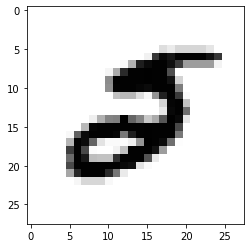

In [147]:

#Just a visualisation of a wrong prediction   
nn=list(np.where(predictions!=y_test3))[0][88]
print(F'predicted:{predictions[nn]}')
print(F'real value:{y_test3[nn]}')
i=nn
plt.imshow(poly_test[i].reshape(28, 28), interpolation='nearest',cmap='Greys')
plt.show()

# 3. Counting Poissons

The `data/fish.csv` is a data set of camping trips taken by 250 groups of people.

- The campers may or may not have done some fishing during their trip.
- If a group did some fishing, they would have caught zero or mor fish.
- We want to estimate not only how many fish were caught (if there was fishing done by a camping group), but also the probability that the camping group caught any fish at all.

Here's info on the columns:

**FISH_COUNT:** The number of fish that were caught. This will be our dependent variable y.

**LIVE_BAIT:** A binary variable indicating whether live bait was used.

**CAMPER:** Whether the fishing group used a camper van.

**PERSONS:** Total number of people in the fishing group. Note that in some groups, none of them may have fished.

**CHILDREN:** The number of children in the camping group.

Your task is to predict the number of fish caught (FISH_COUNT) by a camping group based on the values of LIVE_BAIT, CAMPER, PERSONS and CHILDREN variables.

Use what we learned on count variables and zero-inflated datasets to achieve the best model you can.

Interpret the models you used to give an analysis of each feature's effect on the predicted fish caught.

**N.B.** Please appreciate the effort I went through to find a fish dataset for a count problem pun.

Optimization terminated successfully.
         Current function value: 2.875290
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
C:\Users\kevin\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  125
Model:             ZeroInflatedPoisson   Df Residuals:                      120
Method:                            MLE   Df Model:                            4
Date:                 Wed, 10 Feb 2021   Pseudo R-squ.:                  0.4826
Time:                         21:21:37   Log-Likelihood:                -359.41
converged:                        True   LL-Null:                       -694.60
Covariance Type:             nonrobust   LLR p-value:                9.024e-144
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.8381      0.305     -2.750      0.006      -1.435      -0.241
const            -4.1684      0.409    -10.202      0.000      -4.969      -3.368
LIVE_BAIT         1.9080      0.324      5.886      0.000       1.273       2.543
CAMPER            1.3370      0.123     10.836      0.000       1.095       1.579
PERSONS           1.1975      0.063     19.072      0.000       1.074       1.321
CHILDREN         -1.5901      0.147    -10.851      0.000      -1.877      -1.303
=================================================================================
"""

Test accuracy =  0.496


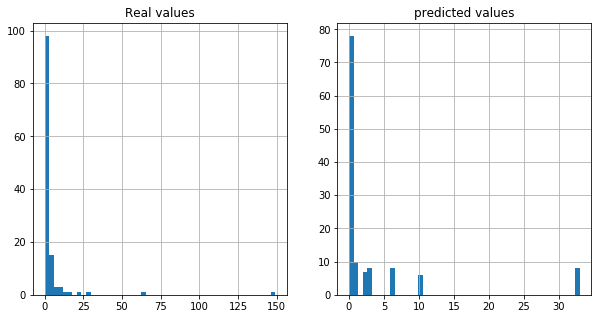

In [148]:
df=pd.read_csv('data/fish.csv')

X=df.copy()
y=X.FISH_COUNT
X=X.drop('FISH_COUNT',axis=1)

n=1

poly = PolynomialFeatures(degree = n,include_bias=False,interaction_only=False)
poly_train=poly.fit_transform(X)
poly_train=pd.DataFrame(poly_train)
poly_train.columns=poly.get_feature_names(X.columns)

#getting all the binary columns and adds \^
#reason: I want to drop all the binary columns that have powers on them 
# of else the matrix will be singular  
# I do that before adding the constant term 
bi_cols = [col+'\^' for col in X if 
               X[col].dropna().value_counts().index.isin([0,1]).all()]

Remove_cols=poly_train.columns[
    poly_train.columns.str.contains('|'.join(bi_cols))]

poly_train=poly_train.drop(Remove_cols,axis=1)

all_zero=poly_train.columns[(poly_train == 0).all()]
poly_train=poly_train.drop(all_zero,axis=1)



poly_train=sm.add_constant(poly_train)

# spliting the test and train data after every columns/values has been droped
poly_train, x_test4, y, y_test4 = train_test_split(poly_train, y, test_size=5/10, random_state=0)


est = sm.ZeroInflatedPoisson(y,poly_train).fit()
#est = sm.Poisson(y,poly_train).fit()

display(est.summary())

# accuracy score of the model 
predictions=est.predict(x_test4).astype(int)
print('Test accuracy = ', accuracy_score(y_test4, predictions ))


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
y.hist(ax=ax1,bins=50)
predictions.hist(ax=ax2,bins=50)
ax1.set_title('Real values')
ax2.set_title('predicted values')

plt.show()


#Best model I got 
#ZeroInflatedPoisson with no interaction between the features
#with 49.6% accuracy 
# and I have the same accuracy with n=4 with only interaction 



#The next cells are just things I tried but the models were not better



#note  I have an accuracy of 50.4% with n=4 with not only ineractions
#but some got more than 600 fishes  and we can see with the graph 
#that the prediction is not that good, the accuracy is mosly because 
#it predicted the number of people who got no fish better



#interpretation 

#LIVE_BAIT --> more fish  (positive sign)
#Camper van --> more fish (positive sign)
#more people --> more fish  (positive sign)
# CHILDREN--> less fish (negative sign)


Optimization terminated successfully.
         Current function value: 0.512982
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.735201
         Iterations: 30
         Function evaluations: 32
         Gradient evaluations: 32

Test accuracy =  0.248
C:\Users\kevin\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:              FISH_COUNT   No. Observations:                  125
Model:             ZeroInflatedPoisson   Df Residuals:                      119
Method:                            MLE   Df Model:                            5
Date:                 Wed, 10 Feb 2021   Pseudo R-squ.:                  0.5078
Time:                         21:21:38   Log-Likelihood:                -341.90
converged:                        True   LL-Null:                       -694.60
Covariance Type:             nonrobust   LLR p-value:                3.336e-150
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.2429      0.226     -1.074      0.283      -0.686       0.200
const            -2.5508      0.440     -5.799      0.000      -3.413      -1.689
LIVE_BAIT         3.6765      0.463      7.948      0.000       2.770       4.583
CAMPER            1.8614      0.153     12.132      0.000       1.561       2.162
PERSONS           2.5987      0.245     10.588      0.000       2.118       3.080
CHILDREN         -4.9807      0.594     -8.388      0.000      -6.144      -3.817
stage1          -10.0438      1.612     -6.232      0.000     -13.203      -6.885
=================================================================================
"""

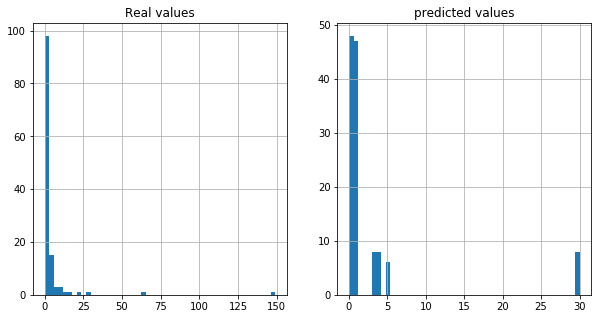

In [149]:
X2=poly_train.copy()
x_test4_2=x_test4.copy()
if n<5:

    est1 = sm.Logit((y > 0).astype(int), X2).fit()
    # Prep Stage 2
    X2['stage1'] = est1.predict(X2)
    x_test4_2['stage1'] = est1.predict(x_test4)

    # Stage 2
    #est2 = sm.Poisson(y,X2).fit()
    est2 = sm.ZeroInflatedPoisson(y,X2).fit()

    predictions=est2.predict(x_test4_2).astype(int)
    print('\nTest accuracy = ', accuracy_score(y, predictions))
    display(est2.summary())


    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
y.hist(ax=ax1,bins=50)
predictions.hist(ax=ax2,bins=50)
ax1.set_title('Real values')
ax2.set_title('predicted values')

plt.show()

Optimization terminated successfully.
         Current function value: 2.939138
         Iterations 11

Test accuracy =  0.288


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:             FISH_COUNT   No. Observations:                  125
Model:                        Poisson   Df Residuals:                      118
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:                  0.6304
Time:                        21:21:39   Log-Likelihood:                -367.39
converged:                       True   LL-Null:                       -993.90
Covariance Type:            nonrobust   LLR p-value:                1.607e-267
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9381      0.766     -6.449      0.000      -6.439      -3.437
LIVE_BAIT      3.5532      0.527      6.745      0.000       2.521       4.586
CAMPER         1.8766      0.174     10.799      0.000       1.536       2.217
PERSONS        2.7375      0.357      7.674      0.000       2.038       3.437
CHILDREN      -5.3395      0.841     -6.350      0.000      -6.988      -3.691
stage1        -4.8503      1.906     -2.545      0.011      -8.586      -1.114
stage1_2      -3.3688      1.963     -1.717      0.086      -7.215       0.478
==============================================================================
"""

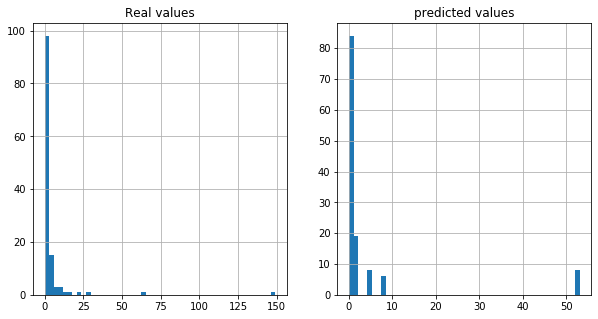

In [150]:
if n<5:    
    X2['stage1_2'] = X2.stage1 ** 2
    x_test4_2['stage_2'] = x_test4_2['stage1']**2

    est3 = sm.Poisson(y,X2).fit()
    #est3 = sm.ZeroInflatedPoisson(y,X2).fit()
    predictions=est3.predict(x_test4_2).astype(int)
    print('\nTest accuracy = ', accuracy_score(y, predictions))
    display(est3.summary())

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    y.hist(ax=ax1,bins=50)
    predictions.hist(ax=ax2,bins=50)
    ax1.set_title('Real values')
    ax2.set_title('predicted values')

    plt.show()

# 5. Survival Question

The `data/telco_churn.csv` dataset comes from [here](https://www.kaggle.com/blastchar/telco-customer-churn) and here is the description:

**Context**

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents


**5.1 StreamingTV churn**

The `Tenure` column is how long the customer lasted. Make the survival curve for both the group using StreamingTV and the one not using it in the dataset

![](streamingtv.png)


**5.2 Survival Regression**

Use either lifelines or statsmodels to implement a survival regression model predicting tenure. Don't forget to use the churn column as the event column.

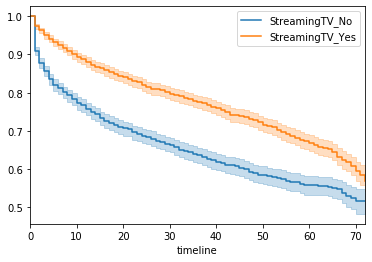

In [152]:
#5.1
import pandas as pd
from lifelines import KaplanMeierFitter
data=pd.read_csv('data/telco_churn.csv')

data2=data.loc[data.StreamingMovies!='No internet service']

data2['Churn'].loc[data2['Churn']=='Yes']=1
data2['Churn'].loc[data2['Churn']=='No']=0

T = data2['tenure']
E = data2['Churn']

col='StreamingTV'

kmf = KaplanMeierFitter()

groups = data[col]
ix = (groups =='Yes')
kmf.fit(T[~ix], E[~ix], label=col+'_No')
ax = kmf.plot_survival_function()
kmf.fit(T[ix], E[ix], label=col+'_Yes')
ax = kmf.plot_survival_function(ax=ax)



<lifelines.CoxPHFitter: fitted with 5517 total observations, 3761 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5517
number of events observed = 1756
   partial log-likelihood = -13973.51
         time fit was run = 2021-02-11 02:21:41 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
gender_Male        -0.01       0.99       0.05            -0.10             0.09                 0.91                 1.09
Partner_Yes        -0.80       0.45       0.06            -0.90            -0.69                 0.40                 0.50
Dependents_Yes     -0.35       0.70       0.07            -0.49            -0.21                 0.61                 0.81
PhoneService_Yes    0.70       2.01       0.10             0.50             0.90                 1.64                 2.47
SeniorCitizen_Yes   0.41       1.50       0.06             0.30             0.52                 1.35                 1.68
StreamingTV_Yes    -0.20       0.82       0.06            -0.32            -0.08                 0.73                 0.92
MonthlyCharges     -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99

                       z      p   -log2(p)
covariate                                 
gender_Male        -0.12   0.90       0.15
Partner_Yes       -14.33 <0.005     152.27
Dependents_Yes     -4.99 <0.005      20.68
PhoneService_Yes    6.73 <0.005      35.77
SeniorCitizen_Yes   7.26 <0.005      41.28
StreamingTV_Yes    -3.27 <0.005       9.84
MonthlyCharges     -6.25 <0.005      31.20
---
Concordance = 0.69
Partial AIC = 27961.02
log-likelihood ratio test = 586.85 on 7 df
-log2(p) of ll-ratio test = 404.55

None


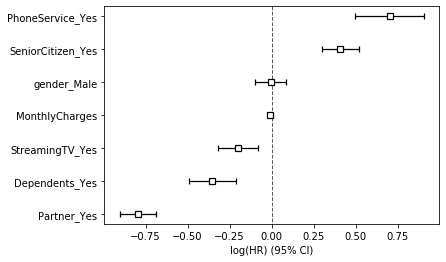

In [153]:
from lifelines import CoxPHFitter
from lifelines import WeibullAFTFitter

data4=data[[
    'tenure','Churn','gender','Partner','Dependents','PhoneService','MonthlyCharges','SeniorCitizen','StreamingTV']]


data4['Churn'].loc[data4['Churn']=='Yes']=1
data4['Churn'].loc[data4['Churn']=='No']=0

data4['SeniorCitizen'].loc[data4['SeniorCitizen']==1]='Yes'
data4['SeniorCitizen'].loc[data4['SeniorCitizen']==0]='No'


data4=data4.loc[data.StreamingMovies!='No internet service']

cat_data=['gender','Partner','Dependents','PhoneService','SeniorCitizen','StreamingTV']
X1=pd.get_dummies(data4[cat_data], drop_first=True)
X2=data4[['tenure','MonthlyCharges','Churn']]

data4=X1.join(X2)

cph = CoxPHFitter()
cph.fit(data4,'tenure', event_col='Churn')
print(cph.print_summary())
cph.plot()


In [154]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
gender_Male,-0.005951,0.994067,0.047809,-0.099654,0.087752,0.905150,1.091718,-0.124474,9.009397e-01,0.150498
Partner_Yes,-0.795988,0.451135,0.055553,-0.904871,-0.687105,0.404594,0.503030,-14.328330,1.455792e-46,152.266888
Dependents_Yes,-0.353682,0.702098,0.070840,-0.492526,-0.214838,0.611081,0.806672,-4.992684,5.954582e-07,20.679496
PhoneService_Yes,0.700493,2.014745,0.104103,0.496454,0.904531,1.642885,2.470773,6.728830,1.710333e-11,35.766932
SeniorCitizen_Yes,0.406390,1.501388,0.055942,0.296747,0.516034,1.345474,1.675369,7.264550,3.742819e-13,41.280940
StreamingTV_Yes,-0.200573,0.818262,0.061428,-0.320970,-0.080175,0.725445,0.922955,-3.265149,1.094066e-03,9.836085
MonthlyCharges,-0.011117,0.988945,0.001778,-0.014602,-0.007632,0.985504,0.992397,-6.251683,4.060539e-10,31.197610
